In [1]:
import sys
sys.path.append(r'C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading\utils')
from trading_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe,
                          calc_romad)


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import (train_test_split,  
                                     KFold, 
                                     cross_val_score,
                                     cross_val_predict,
                                    )
from datetime import datetime, timedelta, time
import plotly.graph_objects as go
import sklearn.metrics as metrics
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import scikitplot as skplt
import xgboost as xgb
import pandas as pd
import numpy as np
import requests
import asyncio 
import aiohttp  # pip install aiohttp aiodns 
import pickle
import talib
import time
import json
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import pandas as pd
pd.options.display.max_rows= 1000
pd.options.display.max_columns= 1000
import time

import predict_crypto_prices as pcp

In [5]:
data_source = 'fx' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
#                  'EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv',
                 'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
#                  'NZDUSD_1h_2003-2020.csv',
#                  'AUDUSD_1h_2003-2020.csv',
#                  'USDCAD_1h_2003-2020.csv',
                 ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2020-04-28'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)

USDJPY_1h_2003-2010.csv
USDJPY_1h_2010-2020.csv


In [6]:
full_files = []
for file, data in loaded_files.items():
    print(file)
    data['daily_return'] = (data['close'].pct_change()*100)
    data['target'] = (data['daily_return']).shift(-1)  
    data = pcp.feature_pipeline(data, volume_col='volume')
    full_data = pcp.feature_pipeline(data, volume_col='volume')
    full_files.append(full_data)
    
all_data = pd.concat(full_files)
all_data.reset_index(inplace=True, drop=True)
all_data = all_data.iloc[:,6:]

USDJPY_1h_2003-2010.csv
USDJPY_1h_2010-2020.csv


In [7]:
#all_data.to_csv('eurusd_xgboost_data.csv', index=False)
#all_data = pd.read_csv('eurusd_xgboost_data.csv', index_col=False)

In [30]:
binary_perc = all_data['target'].value_counts(normalize=True).values
print('binary class proportions', binary_perc)
if 'time' in list(all_data.columns):
    time_col = all_data['time'].copy()
    all_data.drop('time',axis='columns',inplace=True)
real_target = all_data['target'].copy()
all_data = pcp.normalize(all_data)
data = all_data

binary class proportions [0.50180357 0.49819643]


In [31]:
features = [col for col in data.columns.to_list() if col != 'target']
X_train, X_test, y_train, y_test = train_test_split(data[features], data['target'], test_size=0.2, shuffle=False)

In [32]:
model = xgb.XGBClassifier(objective='binary:logistic')

In [33]:
print('fitting model')
model.fit(X_train, y_train)

fitting model


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [34]:
#model.save_model('model.json')
#model.load_model('model.json')

In [35]:
pred_dataset_x = X_test
pred_dataset_y = y_test
y_predict_proba = model.predict_proba(pred_dataset_x)
predictions = model.predict(pred_dataset_x)

Accuracy: 0.524 | Class percentage: 0.502 | Improvement (>1?): 1.043


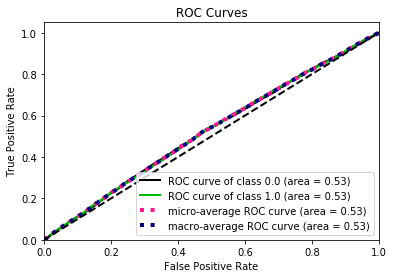

In [36]:
output_accuracy_text = pcp.output_accuracy(True, 'classification', pred_dataset_y,
                                           y_predict_proba, predictions, binary_perc)

total profit: 267.0
total profit after 1 pip fees: 57.980000000000715


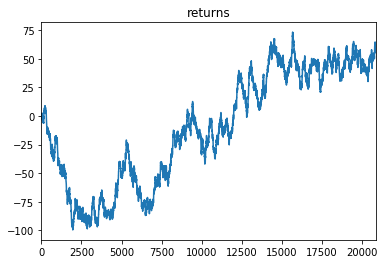

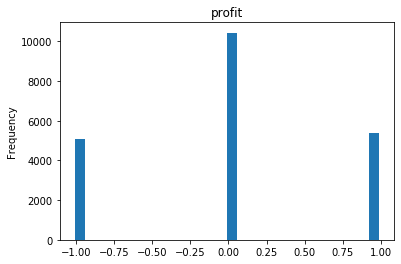

0.25666172319762715

In [37]:
returns = pd.DataFrame(X_test['daily_return'].copy())
returns.reset_index(inplace=True, drop=True)
tanh_predictions = np.where(predictions == 0, -1, 1)
returns['predictions'] = pd.Series(tanh_predictions)
returns['predictions'] = returns['predictions'].shift(1)
returns['profit'] = real_target * returns['predictions']
print('total profit:',returns['profit'].sum())
returns['profit'] -= 0.01 # add fees
print('total profit after 1 pip fees:',returns['profit'].sum())
returns['return'] = returns['profit'].cumsum()
returns['return'].plot(title='returns')
plt.show()
returns['profit'].plot.hist(title='profit', bins=30)
plt.show()
(returns['profit'] >= 0).sum() / len(returns)